<a href="https://colab.research.google.com/github/rkrafif121/Project-Capstone-Hactiv8/blob/main/Project_BISMILLAH_FIX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade pip setuptools wheel
!pip install --quiet "langchain-community>=0.0.30" replicate pandas numpy matplotlib scikit-learn


In [2]:
import os, json, time, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from langchain_community.llms import Replicate

try:
    from google.colab import userdata
    api_token = userdata.get('REPLICATE_API_TOKEN')
except Exception:
    api_token = None

if not api_token:
    api_token = os.getenv('REPLICATE_API_TOKEN')

if not api_token:
    from getpass import getpass
    api_token = getpass("Masukkan REPLICATE_API_TOKEN Anda (disembunyikan): ")

os.environ["REPLICATE_API_TOKEN"] = api_token

MODEL_NAME = "ibm-granite/granite-3.3-8b-instruct"
granite = Replicate(model=MODEL_NAME, replicate_api_token=api_token)
print("Granite LLM siap:", MODEL_NAME)

Granite LLM siap: ibm-granite/granite-3.3-8b-instruct


In [3]:
paths_to_try = [
    "/content/global_inflation_data.csv",
    "/mnt/data/global_inflation_data.csv",
    "global_inflation_data.csv",
    "/content/drive/MyDrive/global_inflation_data.csv"
]

df = None
for p in paths_to_try:
    try:
        df = pd.read_csv(p)
        print("Loaded:", p)
        break
    except:
        pass

if df is None:
    try:
        from google.colab import files
        uploaded = files.upload()
        fn = list(uploaded.keys())[0]
        df = pd.read_csv(fn)
        print("Loaded uploaded file:", fn)
    except Exception as e:
        raise RuntimeError("Gagal menemukan file CSV. Pastikan meng-upload file global_inflation_data.csv.") from e

print("Shape:", df.shape)
display(df.head())

Saving global_inflation_data.csv to global_inflation_data.csv
Loaded uploaded file: global_inflation_data.csv
Shape: (196, 47)


,country_name,indicator_name,1980,1981,1982,1983,1984,1985,1986,1987,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Afghanistan,Annual average inflation (consumer prices) rate,13.4,22.2,18.2,15.9,20.4,8.7,-2.1,18.4,...,-0.66,4.38,4.98,0.63,2.3,5.44,5.06,13.71,9.1,NaN
1,Albania,Annual average inflation (consumer prices) rate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.90,1.30,2.00,2.00,1.4,1.60,2.00,6.70,4.8,4.0
2,Algeria,Annual average inflation (consumer prices) rate,9.7,14.6,6.6,7.8,6.3,10.4,14.0,5.9,...,4.80,6.40,5.60,4.30,2.0,2.40,7.20,9.30,9.0,6.8
3,Andorra,Annual average inflation (consumer prices) rate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.10,-0.40,2.60,1.00,0.5,0.10,1.70,6.20,5.2,3.5
4,Angola,Annual average inflation (consumer prices) rate,46.7,1.4,1.8,1.8,1.8,1.8,1.8,1.8,...,9.20,30.70,29.80,19.60,17.1,22.30,25.80,21.40,13.1,22.3


In [4]:

from sklearn.linear_model import LinearRegression


df_long = df.reset_index()
df_long = df_long.melt(
    id_vars=['country_name', 'indicator_name'],
    var_name='year',
    value_name='inflation'
)


df_long['year'] = pd.to_numeric(df_long['year'], errors='coerce')
df_long['inflation'] = pd.to_numeric(df_long['inflation'], errors='coerce')

df_long.dropna(subset=['year'], inplace=True)


def country_summary(cname):

    if 'country_name' not in df_long.columns:
        return None

    sub = df_long[df_long['country_name'] == cname].sort_values('year').dropna(subset=['inflation'])

    if len(sub) < 2:
        return None

    ys = sub['inflation'].values
    xs = sub['year'].values.astype(float)

    lr = LinearRegression()
    lr.fit(xs.reshape(-1,1), ys)
    slope = lr.coef_[0]
    last_year = int(xs[-1])
    last_val = float(ys[-1])
    prev_val = float(ys[-2]) if len(ys)>=2 else last_val
    diffs = np.diff(ys)
    volatility = float(np.nanstd(diffs)) if len(diffs)>0 else 0.0
    trend = "increasing" if slope > 0.5 else ("decreasing" if slope < -0.5 else "stable")
    return {
        "country": cname,
        "latest_year": last_year,
        "latest_infl": last_val,
        "prev_infl": prev_val,
        "slope": slope,
        "volatility": volatility,
        "trend": trend
    }


if 'country_name' in df_long.columns:
    countries = df_long['country_name'].unique().tolist()
    summaries = []
    for c in countries:
        s = country_summary(c)
        if s:
            summaries.append(s)

    summaries = sorted(summaries, key=lambda x: x['latest_infl'], reverse=True)
    print("Countries summarized:", len(summaries))
    display(pd.DataFrame(summaries).head(10))
else:
    print("Error: 'country_name' column not found after melting the DataFrame.")

Countries summarized: 196


,country,latest_year,latest_infl,prev_infl,slope,volatility,trend
0,Zimbabwe,2024,222.4,314.5,4.525236,110.515915,increasing
1,Venezuela,2024,200.0,360.0,194.952846,12242.568490,increasing
2,Lebanon,2022,171.2,154.8,-1.153096,83.775543,decreasing
3,Sudan,2024,152.4,256.2,1.773505,59.260481,increasing
4,Argentina,2024,93.7,121.7,3.132617,15.162414,increasing
5,"Türkiye, Republic of",2024,62.5,51.2,-1.159855,17.744018,decreasing
6,Sri Lanka,2022,45.2,6.0,-0.118635,8.274119,stable
7,Iran,2024,32.5,47.0,0.251924,9.112568,stable
8,Egypt,2024,32.2,23.5,-0.059051,5.600201,stable
9,Suriname,2024,30.9,53.3,0.182424,28.865201,stable


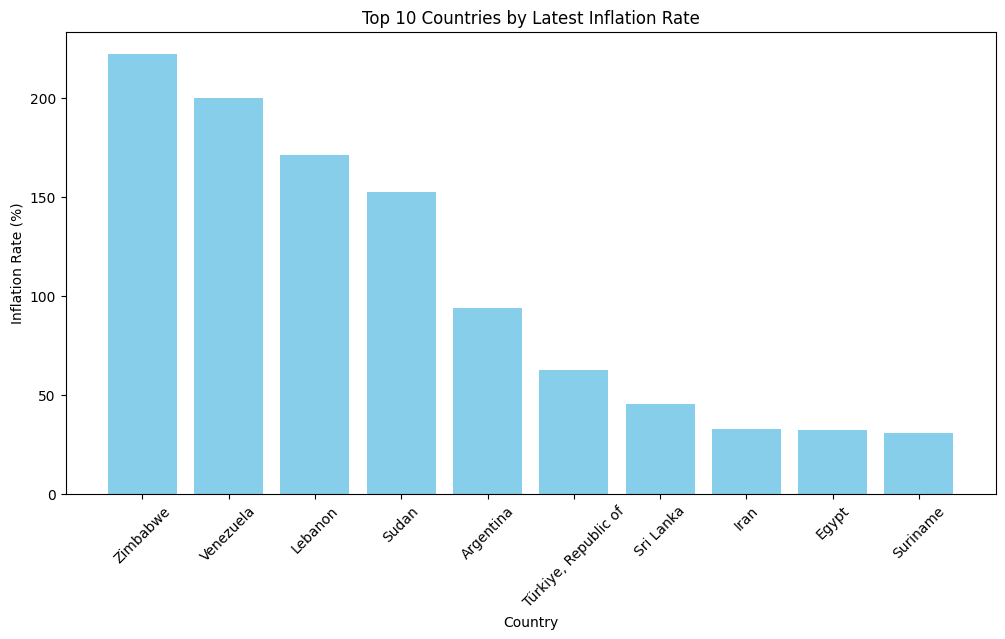

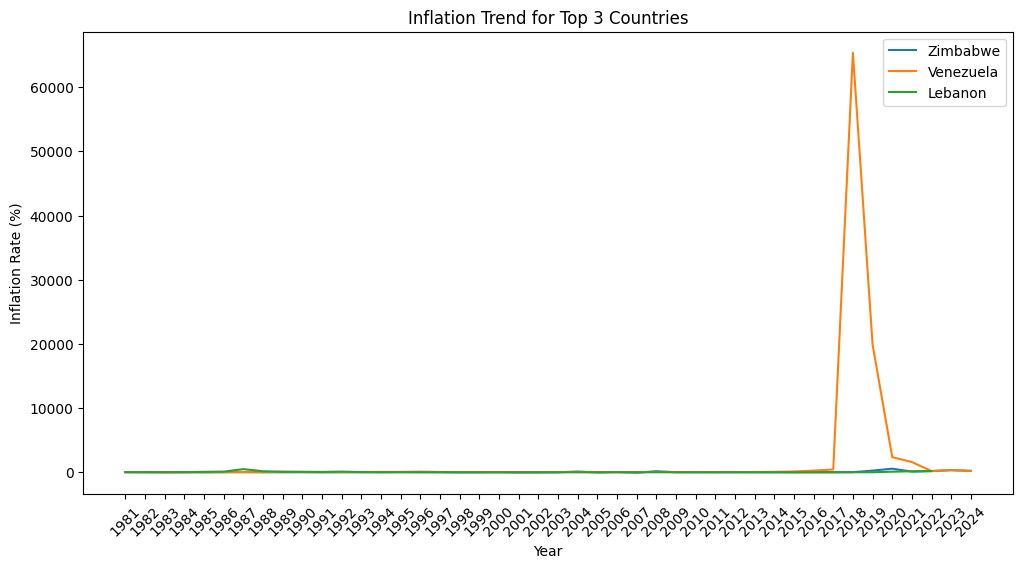

In [6]:
top_df = pd.DataFrame(summaries[:10])
plt.figure(figsize=(12, 6))
plt.bar(top_df['country'], top_df['latest_infl'], color='skyblue')
plt.title('Top 10 Countries by Latest Inflation Rate')
plt.xlabel('Country')
plt.ylabel('Inflation Rate (%)')
plt.xticks(rotation=45)
plt.show()

top_countries = top_df['country'].head(3).tolist()

# Transpose the original DataFrame and set the index
df_transposed = df.set_index('country_name').T

plt.figure(figsize=(12, 6))
for country in top_countries:
    # Select the series for the country, ensuring the index is numeric (years)
    series = df_transposed[country].iloc[2:] # Skip first two rows ('indicator_name' and first year)
    series = pd.to_numeric(series, errors='coerce').dropna() # Convert to numeric and drop NaNs

    if not series.empty: # Only plot if there is data
        plt.plot(series.index, series, label=country)

plt.title('Inflation Trend for Top 3 Countries')
plt.xlabel('Year')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [9]:
def make_item_text(s):
    return (f"Country: {s['country']}\n"
            f"Latest year: {s['latest_year']}\n"
            f"Latest inflation (%): {s['latest_infl']:.2f}\n"
            f"Previous inflation (%): {s['prev_infl']:.2f}\n"
            f"Trend slope: {s['slope']:.3f}\n"
            f"Volatility (std diff): {s['volatility']:.3f}\n")

N = 10
items = summaries[:N]
items_text = "\n\n".join([make_item_text(it) for it in items])
median_vol = np.median([it['volatility'] for it in items if it['volatility'] is not None])

prompt_template = f"""
You are an economic analyst. For each country item below, return a JSON array only (no extra text).
Each object must have:
- country
- category (Deflation, Low (<3%), Moderate (3-7%), High (7-20%), Very High (>20%))
- tags (list: increasing, decreasing, stable, volatile)
- reasoning (one short line)

Use latest_infl for category. Tag as volatile if volatility > {median_vol:.3f}.

Items:
{items_text}
"""

print("Prompt siap.")

Prompt siap.


In [8]:
parameters = {
    "top_k": 0,
    "top_p": 1.0,
    "max_tokens": 8192,
    "min_tokens": 0,
    "random_seed": None,
    "repetition_penalty": 1.2
}

print("Invoking Granite...")
response = granite.invoke(prompt_template, parameters=parameters)
print("Raw response:\n", response)

Invoking Granite...
Raw response:
 [
  {
    "country": "Zimbabwe",
    "category": "Very High",
    "tags": ["decreasing"],
    "reasoning": "Inflation has decreased from 314.50% to 222.40%, but remains very high."
  },
  {
    "country": "Venezuela",
    "category": "Very High",
    "tags": ["decreasing"],
    "reasoning": "Inflation has decreased from 360.00% to 200.00%, but remains very high due to high volatility."
  },
  {
    "country": "Lebanon",
    "category": "High",
    "tags": ["decreasing"],
    "reasoning": "Inflation has decreased from 154.80% to 171.20%, placing it in the high category."
  },
  {
    "country": "Sudan",
    "category": "High",
    "tags": ["decreasing"],
    "reasoning": "Inflation has decreased from 256.20% to 152.40%, placing it in the high category."
  },
  {
    "country": "Argentina",
    "category": "Moderate",
    "tags": ["decreasing"],
    "reasoning": "Inflation has decreased from 121.70% to 93.70%, falling into the moderate category."
  },
 

In [10]:
import re
import json

clean_response = re.sub(r'^[^\[]*', '', response)
clean_response = re.sub(r'[^\]]*$', '', clean_response)

clean_response = clean_response.strip()

if not clean_response.endswith(']') and not clean_response.endswith('}'):
    last_comma_pos = clean_response.rfind('},')
    if last_comma_pos != -1:
        clean_response = clean_response[:last_comma_pos + 1] + ']'
        print("Removed incomplete last object and closed array.")
    else:
        clean_response = '[]'
        print("No complete array; fallback to empty.")

print("Cleaned response for parsing:\n", clean_response)

try:
    classifications = json.loads(clean_response)
    print("Classifications parsed successfully:")
    display(pd.DataFrame(classifications))
except json.JSONDecodeError as e:
    print("Error parsing full JSON:", e)
    print("Attempting partial parse...")

    pattern = r'\{\s*"country"\s*:\s*".*?"\s*,\s*"category"\s*:\s*".*?"\s*,\s*"tags"\s*:\s*\[.*?\]\s*,\s*"reasoning"\s*:\s*".*?"\s*\}'
    objects = re.findall(pattern, clean_response, re.DOTALL)

    classifications = []
    for obj_str in objects:
        try:
            obj = json.loads(obj_str)
            classifications.append(obj)
        except json.JSONDecodeError:
            print("Skipped invalid object:", obj_str[:50] + "...")

    if classifications:
        print("Partially parsed classifications:")
        display(pd.DataFrame(classifications))
    else:
        print("No valid objects parsed; using empty list.")
        classifications = []

Cleaned response for parsing:
 [
  {
    "country": "Zimbabwe",
    "category": "Very High",
    "tags": ["decreasing"],
    "reasoning": "Inflation has decreased from 314.50% to 222.40%, but remains very high."
  },
  {
    "country": "Venezuela",
    "category": "Very High",
    "tags": ["decreasing"],
    "reasoning": "Inflation has decreased from 360.00% to 200.00%, but remains very high due to high volatility."
  },
  {
    "country": "Lebanon",
    "category": "High",
    "tags": ["decreasing"],
    "reasoning": "Inflation has decreased from 154.80% to 171.20%, placing it in the high category."
  },
  {
    "country": "Sudan",
    "category": "High",
    "tags": ["decreasing"],
    "reasoning": "Inflation has decreased from 256.20% to 152.40%, placing it in the high category."
  },
  {
    "country": "Argentina",
    "category": "Moderate",
    "tags": ["decreasing"],
    "reasoning": "Inflation has decreased from 121.70% to 93.70%, falling into the moderate category."
  },
  {
 

,country,category,tags,reasoning
0,Zimbabwe,Very High,[decreasing],Inflation has decreased from 314.50% to 222.40...
1,Venezuela,Very High,[decreasing],Inflation has decreased from 360.00% to 200.00...
2,Lebanon,High,[decreasing],Inflation has decreased from 154.80% to 171.20...
3,Sudan,High,[decreasing],Inflation has decreased from 256.20% to 152.40...
4,Argentina,Moderate,[decreasing],Inflation has decreased from 121.70% to 93.70%...
5,"Türkiye, Republic of",Low,[decreasing],"Inflation has decreased from 51.20% to 62.50%,..."
6,Sri Lanka,Deflation,[increasing],"Inflation has decreased from 6.00% to 45.20%, ..."


In [12]:
global_prompt = f"""
Summarize global inflation from these country snapshots:
{items_text}

Give:
- 2-3 sentence executive summary
- Top 3 risks (bullets)
- Top 3 recommendations (bullets)
"""

parameters_summary = {
    "top_k": 10,
    "top_p": 0.9,
    "max_tokens": 8192,
    "repetition_penalty": 1.3
}

summary_resp = granite.invoke(global_prompt, parameters=parameters_summary)
print("Global summary:\n", summary_resp)
with open("global_inflation_summary.txt", "w") as f:
    f.write(summary_resp)

Global summary:
 - Executive Summary: The provided country snapshots reveal that several nations, including Zimbabwe (222.40%), Venezuela (200.00%), and Sudan (152.40%), are grappling with hyperinflation in 2024, significantly higher than the global average. Lebanon exhibits a declining trend (-1.153), while others like Türkiye, Iran, Egypt, and Suriname show moderate inflation rates. Argentina's trend is positive but less severe (3.133%). Volatility is high in Venezuela and Lebanon, indicating unpredictable inflationary pressures.

- Top 3 Risks:
  - **Hyperinflation Risk**: Countries like Zimbabwe, Venezuela, and Sudan face severe economic instability due to hyperinflation, potentially leading to currency devaluation and social unrest.
  - **Policy Ineffectiveness Risk**: The inconsistent trends in some countries (e.g., Türkiye's negative slope) suggest that monetary policies might not be adequately curbing inflation, posing a risk to economic stability.
  - **External Shock Risk**: 